# Evaluation

This Notebook contains the evaluation of all used machine learning models during this project. \
Evaluation and Validation will be performed on the test and validation data 

In [42]:
# Imports 
import numpy as np
import sys
sys.path.append("..")
import pandas as pd 
import matplotlib.pyplot as plt
from model.helpers import *
from model.predict import *
from collections import defaultdict
from sklearn.metrics import (
    roc_curve, auc,
    precision_recall_curve)
import seaborn as sns

from plotly.offline import init_notebook_mode
import matplotlib.pyplot as plt
import warnings  
warnings.filterwarnings('ignore')

init_notebook_mode(connected=True)

In [28]:
#load data 
TRAIN = {}
TEST = {}
VALIDATION = {}

path = "../../data/interim/"
train = "train_"
test = "test_"
validation = "validation_"
#  list of scenarios
scenarios = [
        'CVE-2012-2122',
        'CVE-2014-0160',
        'CVE-2017-7529',
        'CVE-2017-12635_6',
        'CVE-2018-3760',
        'CVE-2019-5418',
        'CVE-2020-9484',
        'CVE-2020-13942',
        'CVE-2020-23839',
        'CWE-89-SQL-injection'
]

for i in range(0,len(scenarios)):
    TRAIN[scenarios[i]]= pd.read_pickle(path + "/" + train + scenarios[i] + ".pkl")
    TEST[scenarios[i]] = pd.read_pickle(path + "/" + test + scenarios[i] + ".pkl")
    VALIDATION[scenarios[i]] = pd.read_pickle(path + "/" + validation + scenarios[i] + ".pkl")
            

In [29]:
# load each model for each Scenario

model_type ='IsolationForest'
IsoForests = {}
for i in range(0, len(scenarios)):
# get dict and save mofel for each scenario
    IsoForests[scenarios[i]] = load_model(model_type=model_type, train_data=TRAIN, test_data=TEST, scenario=scenarios[i], contamination_rate=False)

model_type ='LocalOutlierFactor'
lof_ = {}
for i in range(0, len(scenarios)):
# get dict and save mofel for each scenario
    lof_[scenarios[i]] = load_model(model_type=model_type, train_data=TRAIN, test_data=TEST, scenario=scenarios[i], contamination_rate=False)

model_type = 'VariationalAutoencoder'
vae = {}
for i in range(0, len(scenarios)):
# get dict and save mofel for each scenario
    vae[scenarios[i]] = load_model(model_type=model_type, train_data=TRAIN, test_data=TEST, scenario=scenarios[i], contamination_rate=False)


298/298 [==============================] - 0s 619us/step


In [46]:
# get true values to evaluate algorithm
y_true = {}
for i in range(0, len(scenarios)):
    y_true[scenarios[i]] = encode(TEST[scenarios[i]])['exploit'] # remember 0 = inliners, 1 = outliers  

### ROC-AUC Curve

4040/4040 [==============================] - 2s 590us/step


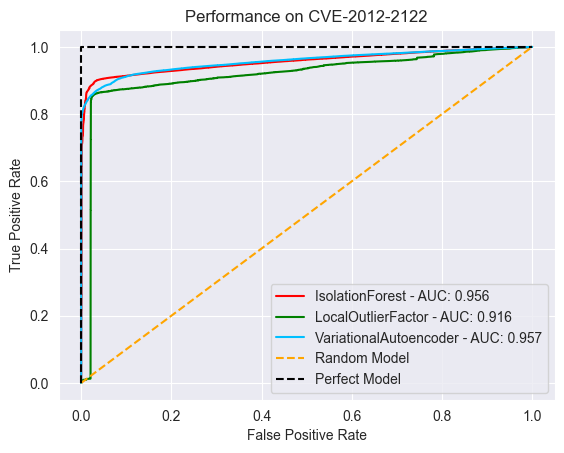

1156/1156 [==============================] - 1s 645us/step


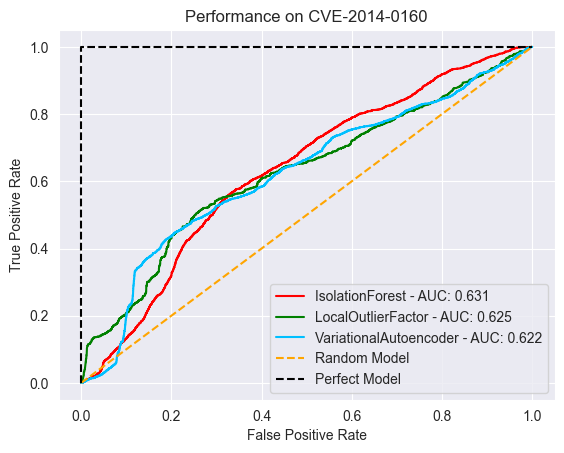

1101/1101 [==============================] - 0s 430us/step


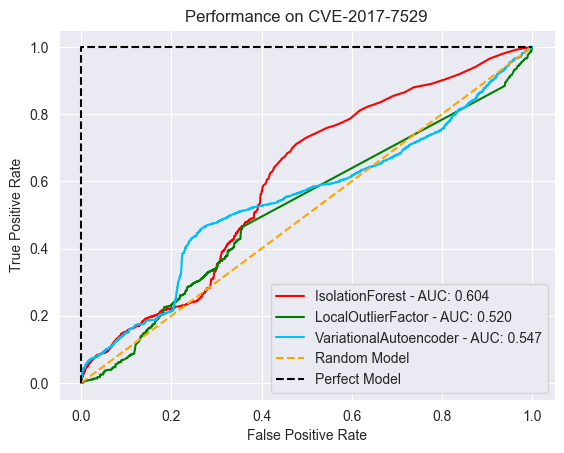

1169/1169 [==============================] - 1s 442us/step


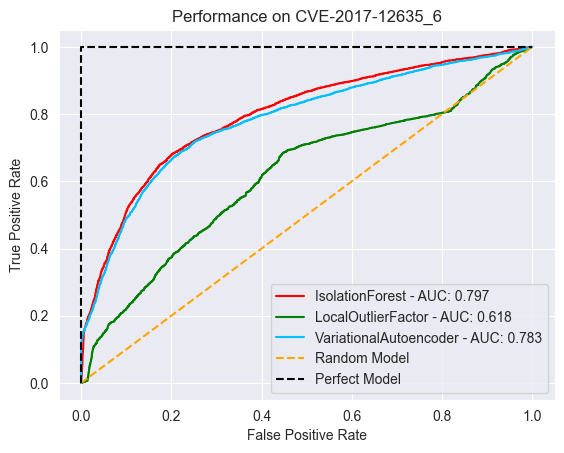

1117/1117 [==============================] - 0s 436us/step


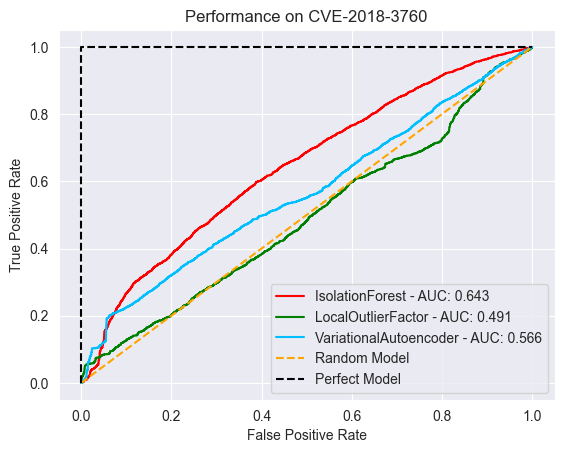

1165/1165 [==============================] - 1s 441us/step


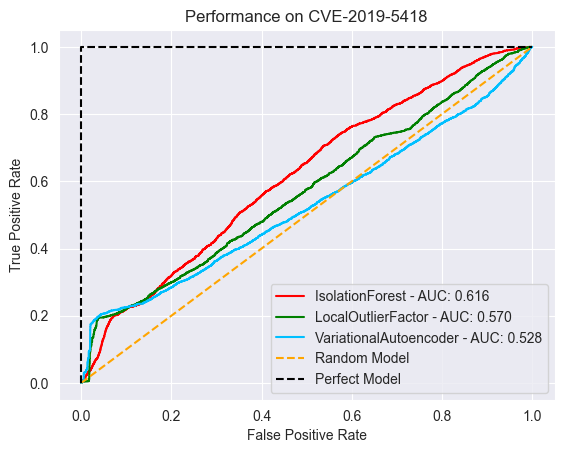

1183/1183 [==============================] - 1s 427us/step


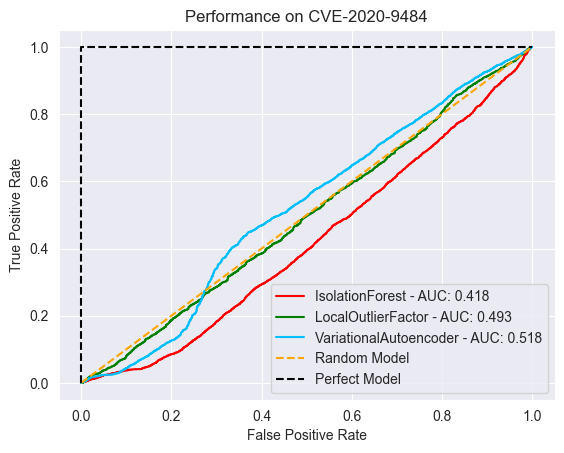

1150/1150 [==============================] - 1s 434us/step


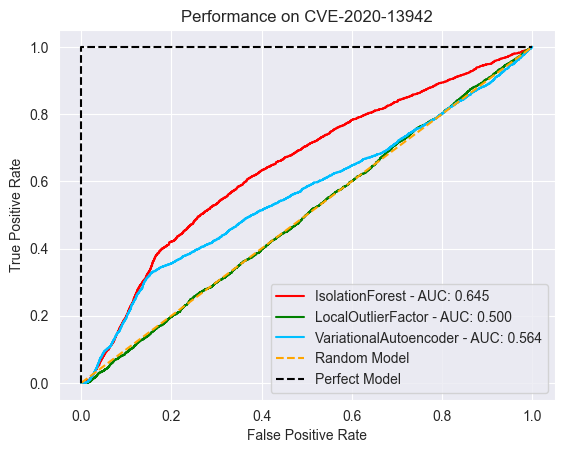

1248/1248 [==============================] - 1s 435us/step


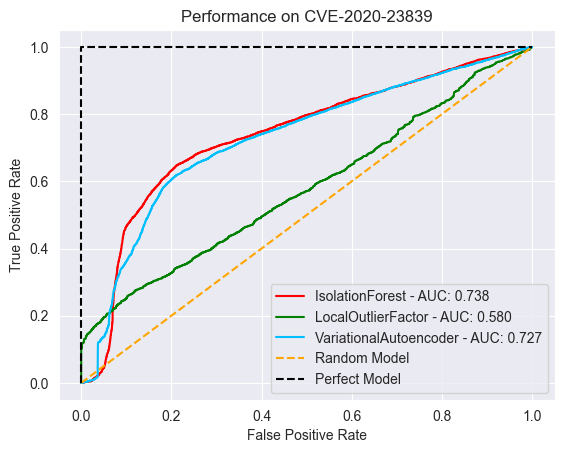

1207/1207 [==============================] - 1s 433us/step


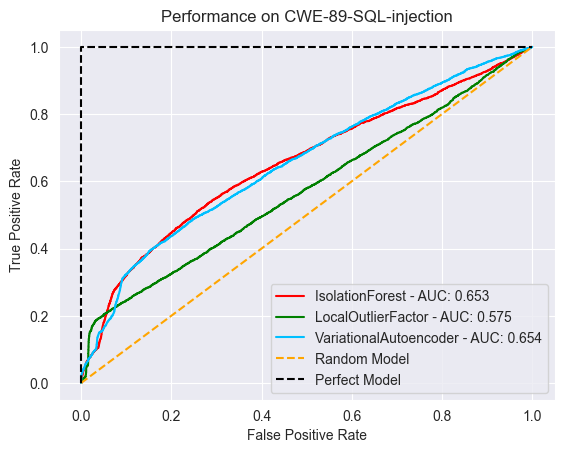

In [36]:
sns.set_style('darkgrid')
name = ['IsolationForest',  'LocalOutlierFactor', 'VariationalAutoencoder']
colors = ['red', 'green', 'deepskyblue']
# Create plots for all scenarios 
for i in range(0,len(scenarios)):
   #scenario = "CVE-2012-2122" 
   # prepare test data 
   X_test = TEST[scenarios[i]]
   X_test = select_columns_for_modelling(X_test)

   algorithms = [ IsoForests[scenarios[i]], lof_[scenarios[i]], vae[scenarios[i]] ] 
  

   fig = plt.figure()
   for a, algo in enumerate(algorithms):
      algo_test = algo.decision_function(X_test)
   
      fpr_test_, tpr_test_, thresholds = roc_curve(y_true[scenarios[i]], algo_test) # Kommt drauf an wie rum(?) nochmal genau reinschauen 
      algo_auc_test = auc(fpr_test_, tpr_test_)
      #J = tpr_test_ - fpr_test_
      #ix = np.argmax(J)
      #best_thresh = thresholds[ix]
      #print(str(name[a]) + ': Best Threshold %f' % (best_thresh))


      
      plt.subplot(1, 1, 1)
      plt.title('Performance on ' + scenarios[i])
      plt.plot(fpr_test_, tpr_test_, color=colors[a], label= '{0} - AUC: {1:.3f}'.format(name[a], algo_auc_test)) #AMV: Augmented Mass Volume Function # AUC ohne 1
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      


   plt.subplot(1, 1, 1)
   plt.plot([0, 1], [0, 1], linestyle='--', label='Random Model', color="orange")
   plt.plot([0,0,1], [0, 1, 1], linestyle='--', label='Perfect Model', color="black")
   plt.legend(loc=0)
   plt.xlim((-0.05, 1.05))
   plt.ylim((-0.05, 1.05))

   plt.show()
   fig.savefig("../../src/plots/models/EVALUATION_ALLMODELS_" + scenarios[i] + ".png")

### Evaluation after Outlier Truncation

Outliers will be truncated using the Interquartile Range (IQR)

In [38]:
no_outliers = {}
for i in range(0,len(scenarios)):
    normal = TEST[scenarios[i]][TEST[scenarios[i]]['exploit']==False]
    attack = TEST[scenarios[i]][TEST[scenarios[i]]['exploit']!=False]
    # chose only cpu_usage and memory_usage
    normal = select_columns_outlier_truncate(normal)
    attack = select_columns_outlier_truncate(attack)
    # calculate IQR for each scenario
    Q1 = normal.quantile(0.25)
    Q3 = normal.quantile(0.75)
    IQR = Q3 - Q1
    normal = normal[~((normal< (Q1 - 1.5 * IQR)) |(normal > (Q3 + 1.5 * IQR))).any(axis=1)]
    no_outliers[scenarios[i]] = pd.concat([normal, attack])


In [39]:
# get all scenarios in one data set at the end
no_outliers_test = []
for key in no_outliers.keys():
    no_outliers[key]['scenario'] = key
    temp_df = no_outliers[key]
    no_outliers_test.append(temp_df)
no_outliers['ALL'] = pd.concat(no_outliers_test)

In [40]:
# get true values to evaluate algorithm
y_true = {}
for i in range(0, len(scenarios)):
    y_true[scenarios[i]] = encode(no_outliers[scenarios[i]])['exploit'] # remember 0 = inliners, 1 = outliers


### ROC-AUC Curve

3983/3983 [==============================] - 2s 456us/step


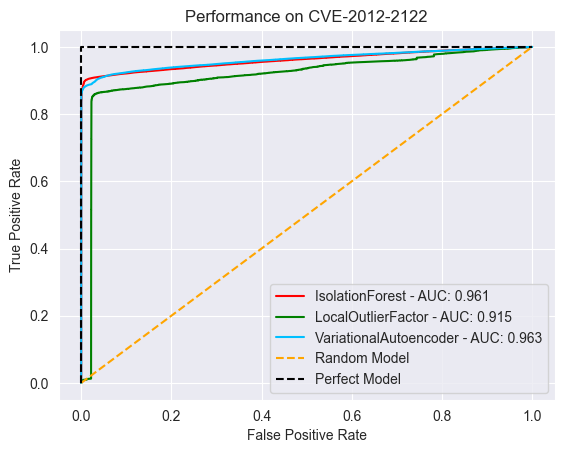

1070/1070 [==============================] - 0s 439us/step


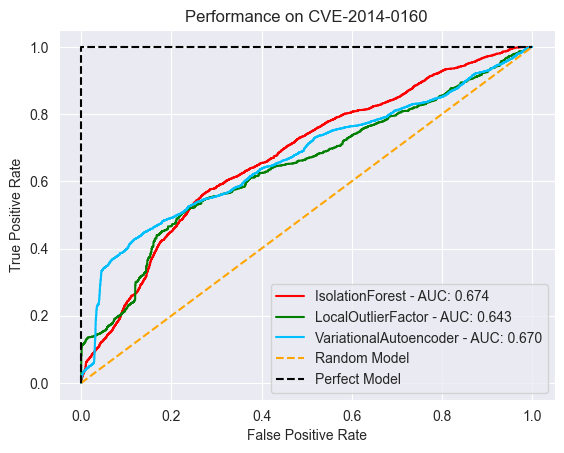

700/700 [==============================] - 0s 446us/step


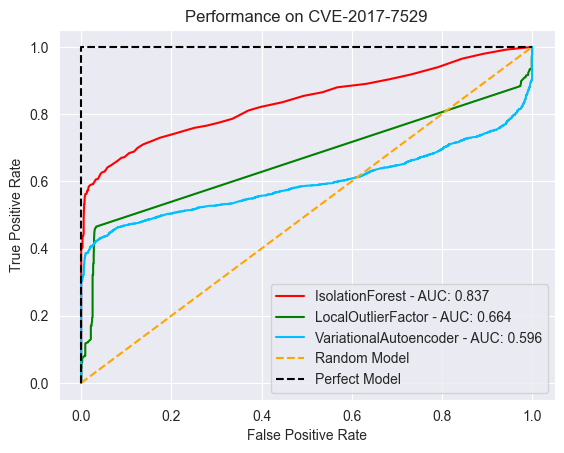

1083/1083 [==============================] - 0s 441us/step


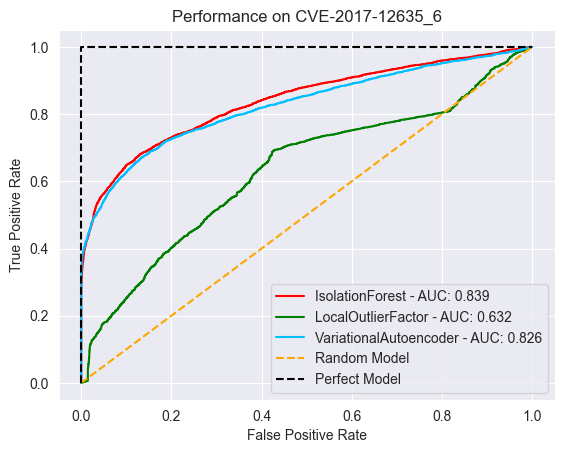

935/935 [==============================] - 0s 436us/step


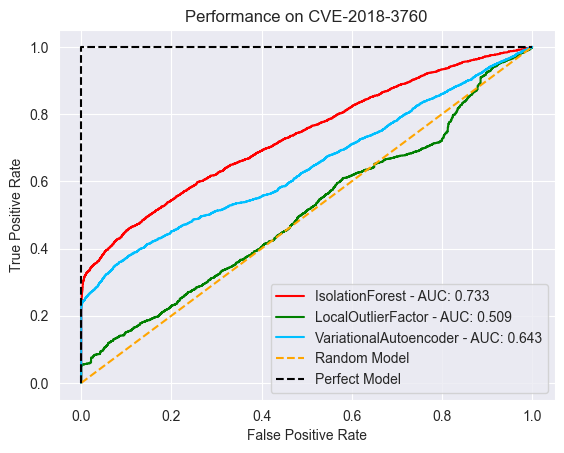

1063/1063 [==============================] - 0s 435us/step


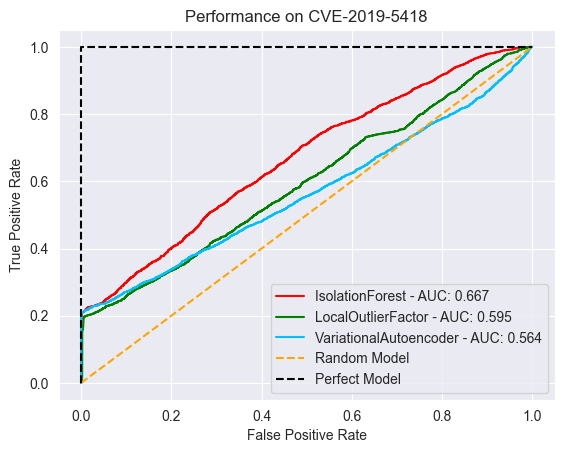

972/972 [==============================] - 0s 431us/step


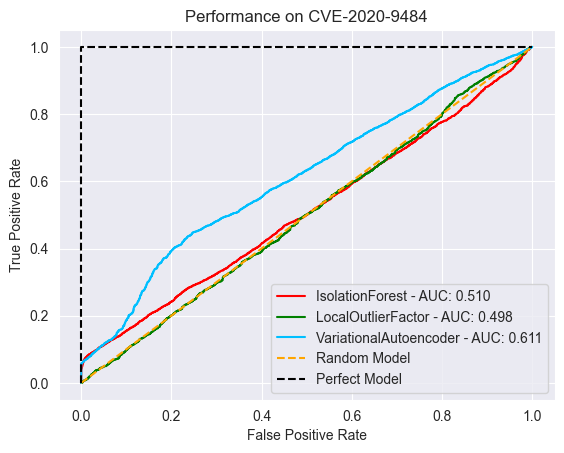

983/983 [==============================] - 0s 432us/step


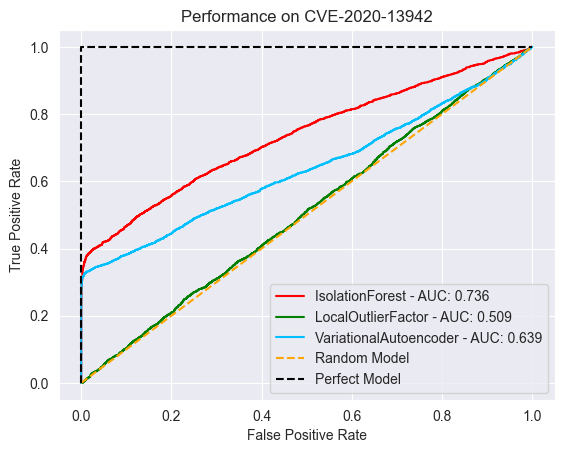

1116/1116 [==============================] - 0s 432us/step


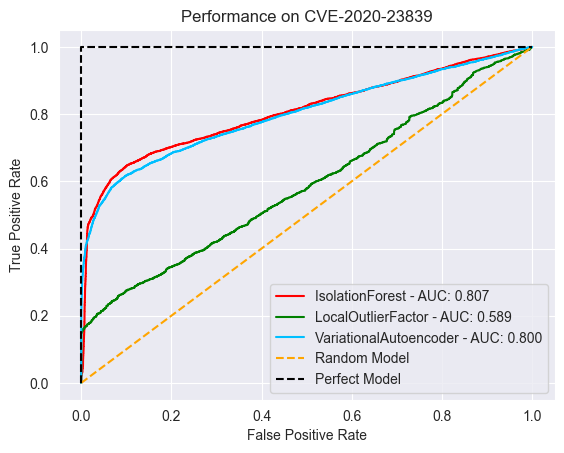

1141/1141 [==============================] - 1s 466us/step


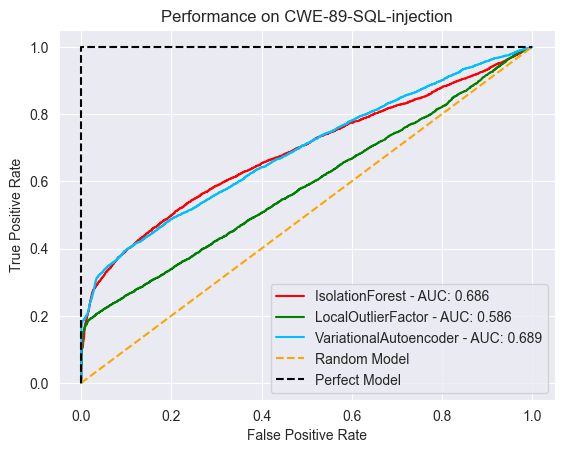

In [41]:
sns.set_style('darkgrid')
name = ['IsolationForest',  'LocalOutlierFactor', 'VariationalAutoencoder']
colors = ['red', 'green', 'deepskyblue']
# Create plots for all scenarios 
for i in range(0,len(scenarios)):
   # prepare test data 
   X_test = no_outliers[scenarios[i]]
   X_test = select_columns_for_modelling(X_test)

   algorithms = [ IsoForests[scenarios[i]], lof_[scenarios[i]], vae[scenarios[i]]] 
  
   fig = plt.figure()
   for a, algo in enumerate(algorithms):
      algo_test = algo.decision_function(X_test)
   
      fpr_test_, tpr_test_, thresholds = roc_curve(y_true[scenarios[i]], algo_test) # Kommt drauf an wie rum(?) nochmal genau reinschauen 
      algo_auc_test = auc(fpr_test_, tpr_test_)
      #J = tpr_test_ - fpr_test_
      #ix = np.argmax(J)
      #best_thresh = thresholds[ix]
      #print(str(name[a]) + ': Best Threshold %f' % (best_thresh))


      
      plt.subplot(1, 1, 1)
      plt.title('Performance on ' + scenarios[i])
      plt.plot(fpr_test_, tpr_test_, color=colors[a], label= '{0} - AUC: {1:.3f}'.format(name[a], algo_auc_test)) #AMV: Augmented Mass Volume Function # AUC ohne 1
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      


   plt.subplot(1, 1, 1)
   plt.plot([0, 1], [0, 1], linestyle='--', label='Random Model', color="orange")
   plt.plot([0,0,1], [0, 1, 1], linestyle='--', label='Perfect Model', color="black")
   plt.legend(loc=0)
   plt.xlim((-0.05, 1.05))
   plt.ylim((-0.05, 1.05))

   plt.show()
   fig.savefig("../../src/plots/models/EVALUATION_ALLMODELS_NO_OUTLIERS" + scenarios[i] + ".png")